## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 支持多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'

In [3]:
import numpy as np
import pandas as pd
import os
import scanpy as sc
import matplotlib.pyplot as plt
from tool.transform_tool import t_or_f
import GRAS4T
from data_read_tool import build_her2st_data, build_stereo_seq_data

## Parameter Setting

In [4]:
from config import Config
args = Config()

In [5]:
args.have_label = True
seed = 2023


## Data Reading

In [6]:
# read gene expression matrix
input_dir = './data/{}/{}/'.format(args.platform, args.dataset_name) + args.slice
adata = sc.read_visium(path=input_dir, count_file=args.slice + '_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
# extract feature from H&E image (when available)
image_feat_path = "./data/{}/{}/image_feature/{}-{}-image_feat.npy".format(args.platform, args.dataset_name,
                                                                           args.slice, args.cnnType_)
image_feat = np.load(image_feat_path)
adata.obsm["image_feat"] = image_feat

In [8]:
# read annotation (when available)
Ann_df = pd.read_csv(
    os.path.join('data/{}/{}/{}_annotations/'.format(args.platform, args.dataset_name, args.dataset_name),
                 args.slice + '_truth.txt'),
    sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

In [9]:
adata

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial', 'image_feat'

## Running GRAS4T

In [10]:
GRAS4T.run(args, seed=seed, use_gpu=args.use_gpu, adata=adata, have_label=args.have_label,
           hid_units_=[64],
           regu_coef=1,
           use_decoder_emb=False,
           activation='prelu',
           muti_act_1='origin',
           muti_act_2='prelu',
           default_resolution=1.5,
           )

number of classes not provided
X_input type:<class 'numpy.ndarray'>, shape:(4226, 3000)
class num:7
A type:<class 'numpy.ndarray'>, shape:(4226, 4226)
--------------------------------------------------
Begin Aug1:[mask]
masked row number: 422
End Aug1:[mask]


Begin Aug2:[HS_image]
added edge number: 7806
droped edge number: 1545
End Aug2:[HS_image]
--------------------------------------------------
USE CUDA!
Begin train...
Epoch 000 | Loss:[2.4133], loss_node_global:[0.7110], loss_node_cluster:[0.7019], loss_feat:[1.0004]
Epoch 100 | Loss:[0.9940], loss_node_global:[0.0071], loss_node_cluster:[0.0097], loss_feat:[0.9772]
Epoch 200 | Loss:[0.9772], loss_node_global:[0.0040], loss_node_cluster:[0.0045], loss_feat:[0.9688]
Epoch 300 | Loss:[0.9657], loss_node_global:[0.0019], loss_node_cluster:[0.0020], loss_feat:[0.9617]
Epoch 400 | Loss:[0.9573], loss_node_global:[0.0011], loss_node_cluster:[0.0011], loss_feat:[0.9551]
End training...
Loading 498th epoch, best loss is 0.950419962406158

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
origin | mclust
 ARI:0.4872, AMI:0.6204, NMI:0.6214, FMI:0.5756
predict number of class =  7
--------------------------------------------------
refine | mclust
 ARI:0.5015, AMI:0.6376, NMI:0.6386, FMI:0.5874
predict number of class =  7
--------------------------------------------------


In [11]:
adata

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'mclust', 'refine_label'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg'
    obsm: 'spatial', 'image_feat', 'emb'

## Visualization

... storing 'Ground Truth' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


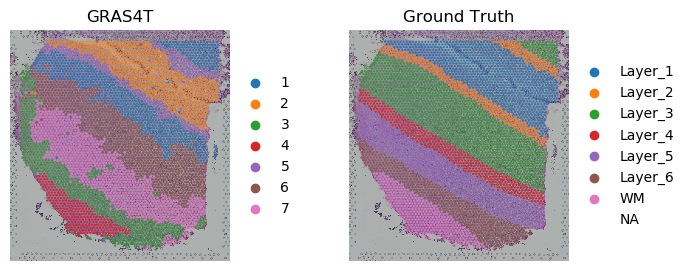

In [12]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=['refine_label', 'Ground Truth'], 
              frameon=False, title=['GRAS4T', 'Ground Truth'])

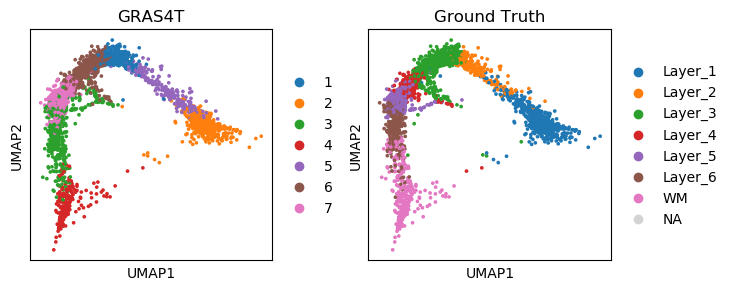

In [13]:
sc.pp.neighbors(adata, use_rep='emb')
sc.tl.umap(adata)
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=["refine_label", "Ground Truth"], 
           title=['GRAS4T', "Ground Truth"])